In [1]:
%matplotlib inline

# This file contains all the main external libs fastai needs
from fastai.imports import *

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


the fastai notebooks imports all the functions into the global namespace, which I find confusing since I don't know what methods are fastai and what are coming from other libraries. 

Ideally I'd like to be able to just call `import fastai as fastai` rather than having multiple import statements. Anyways, using the defaults for now:

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Data

I'm going to use a pretrained NN to solve [Kaggle's dog breed competition](https://www.kaggle.com/c/dog-breed-identification). I used the [kaggle api](https://github.com/Kaggle/kaggle-api) to download the dataset, and in this notebook I work through it step by step:

In [5]:
PATH = '/home/ubuntu/data/dog-breed-identification'
print(PATH)
os.listdir(PATH)

/home/ubuntu/data/dog-breed-identification


['train',
 'sample_submission.csv.zip',
 'labels.csv',
 'test',
 'sample_submission.csv',
 'train.zip',
 'labels.csv.zip',
 'test.zip']

In [30]:
labels = pd.read_csv(PATH + "/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Now to take a look at the data:

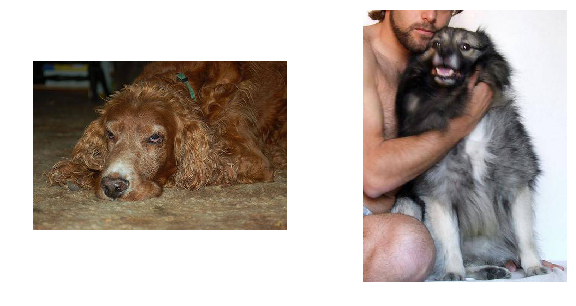

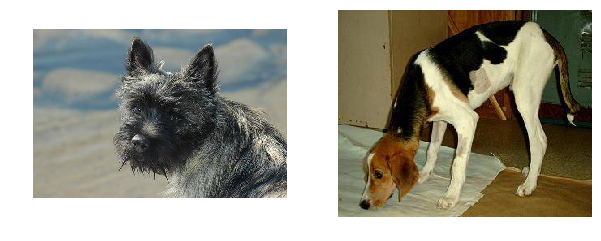

In [27]:
path = PATH + "/train"
plots_from_files(glob(f'{path}/*.*')[0:2])

path = PATH + "/test"
plots_from_files(glob(f'{path}/*.*')[0:2])

# Setup the model

First up, lets find the average image size:

In [55]:
Image.open()

<module 'PIL.Image' from '/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py'>

/home/ubuntu/data/dog-breed-identification/train
Avg image size: 443.33153981608297 386.74721189591077


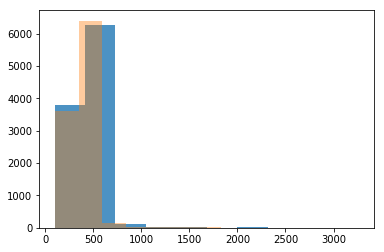

In [85]:
path = PATH + "/train"
print(path)
    
sizes = [Image.open(path+ "/"+ im).size for im in os.listdir(path)]
im_x, im_y = list(zip(*sizes))

plt.hist(im_x, alpha=0.8, label="x sizes")
plt.hist(im_y, alpha=0.4, label="y sizes")
print("Avg image size:", np.mean(im_x), np.mean(im_y))

In [33]:
arch = resnet34 # also try resnext101_64

sz = 128 # we have 28x28x3 image size. what should this number be?
bs = 64 # default is 64

# transforms
#tfms = tfms_from_model(resnet34, sz)
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on)

train_csv = PATH + "/labels.csv"
data = ImageClassifierData.from_csv(PATH, "train", train_csv, tfms=tfms, suffix=".jpg", test_name='test', bs=bs)

### finding a good learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▎ | 107/128 [00:01<00:00, 57.02it/s, loss=25.6]


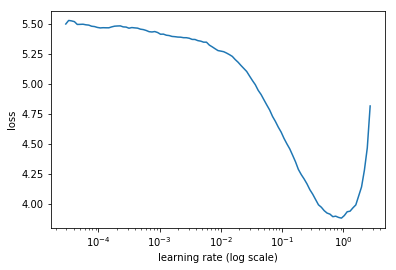

In [48]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
#learn.sched.plot_lr()
learn.sched.plot()

a good starting learning rate seems to be `0.1`

Now to do a initial training run:

In [44]:
lr = 1e-1
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 9)

HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.039046   1.411448   0.606217  
    1      1.536146   1.34553    0.61901                    
    2      1.350199   1.269397   0.645931                   
    3      1.21651    1.303123   0.638607                   
    4      1.155639   1.276013   0.643587                   
    5      1.078132   1.312673   0.644857                   
    6      1.026584   1.302012   0.649349                   
    7      0.986401   1.323386   0.63903                     
    8      0.970146   1.340861   0.642448                    



[1.340861, 0.642447916790843]

Both training and validation loss are decreasing, so I should keep training this for a while longer.

In [88]:
lr = 1e-1
lr_array = np.array([lr/100, lr/10, lr])
learn.unfreeze()

learn.fit(lr_array, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.893727   1.439632   0.58763   
    1      1.604776   1.529545   0.564779                   
    2      0.883746   1.259237   0.630827                    
    3      1.279692   1.819607   0.517285                   
    4      0.833636   1.508472   0.59987                     
    5      0.446818   1.40473    0.623372                    
    6      0.27094    1.381117   0.633138                    
    7      0.793616   2.123619   0.505241                    
    8      0.77383    2.017143   0.514258                    
  7%|▋         | 9/128 [00:05<01:09,  1.70it/s, loss=0.723]

KeyboardInterrupt: 

In [ ]:
learn.save(f"{sz}_{bs}")

## now to predict

We already saved the images to predict in the `test` folder, so...

- learn.TTA() uses test time annealing and returns a tuple, with the first one being the log of probs and the second the y val

In [78]:
# to use TTA use this cell:
#test_log_preds = learn.TTA(is_test=True)
#test_probs = np.exp(test_log_preds[0])

In [89]:
test_log_preds = learn.predict(is_test=True)
test_log_preds[:5]

array([[ -5.05389, -12.20277,  -9.80612, -12.92007, -11.96534, -16.56825,  -9.16446,  -9.86922, -13.22105,
        -14.65923, -10.93008, -13.81445, -14.69398, -14.60811, -16.35855, -14.00642, -10.07672,  -8.89978,
        -12.80306, -10.96448,  -3.8447 , -13.6255 , -12.09013,  -8.66074, -14.93469, -12.61976,  -0.30073,
        -11.20973, -15.12771, -13.4979 , -10.85108, -13.10549, -14.61522, -15.78667, -12.82396, -10.99172,
        -12.26761, -14.30324, -11.74164, -11.45048, -13.93164, -12.5689 , -14.06704, -10.96559, -13.24391,
        -11.18174,  -9.69406, -10.80449,  -6.78537, -16.48923, -13.68387,  -9.65954, -13.66141, -14.0871 ,
         -6.92085, -10.38987, -14.63361,  -9.89132, -14.13363,  -5.80873, -10.50543, -14.74238,  -7.49558,
        -11.54032,  -5.30314,  -8.24101, -12.77826, -12.96248,  -8.91447, -12.04121, -12.91526,  -7.32232,
         -9.48282, -12.04229,  -7.98444, -14.12487, -10.05998,  -7.99591,  -8.61157,  -9.50811,  -8.30396,
         -8.32658, -10.72504, -11.266

In [90]:
test_probs = np.exp(test_log_preds)
print(test_probs.shape)
test_probs[:5]

(10357, 120)


array([[0.00638, 0.00001, 0.00006, 0.     , 0.00001, 0.     , 0.0001 , 0.00005, 0.     , 0.     , 0.00002,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.00004, 0.00014, 0.     , 0.00002, 0.02139, 0.     ,
        0.00001, 0.00017, 0.     , 0.     , 0.74028, 0.00001, 0.     , 0.     , 0.00002, 0.     , 0.     ,
        0.     , 0.     , 0.00002, 0.     , 0.     , 0.00001, 0.00001, 0.     , 0.     , 0.     , 0.00002,
        0.     , 0.00001, 0.00006, 0.00002, 0.00113, 0.     , 0.     , 0.00006, 0.     , 0.     , 0.00099,
        0.00003, 0.     , 0.00005, 0.     , 0.003  , 0.00003, 0.     , 0.00056, 0.00001, 0.00498, 0.00026,
        0.     , 0.     , 0.00013, 0.00001, 0.     , 0.00066, 0.00008, 0.00001, 0.00034, 0.     , 0.00004,
        0.00034, 0.00018, 0.00007, 0.00025, 0.00024, 0.00002, 0.00001, 0.     , 0.     , 0.     , 0.00001,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.00018, 0.00177, 0.06417, 0.07085, 0.00002,
        0.00008, 0.00001, 0.00049, 0.

now to make a csv file for submission:

In [91]:
path

'/home/ubuntu/data/dog-breed-identification/train'

In [118]:
test_labels_df.to_csv(PATH+"submission.csv", index=False)
!head /home/ubuntu/data/digit-recognizer/submission.csv

ImageId,Label
1,9
2,8
3,0
4,0
5,1
6,3
7,3
8,2
9,0
